# CNNAutoencoder_3 — Mathematical Study Guide and Reference

This notebook is a rigorous, step-by-step mathematical reference for the CNNAutoencoder_3 used for histopathology patch reconstruction (150×150×3). It defines the full pipeline with exact equations, size transitions, receptive field analysis, attention, skip connections, objective functions, and visual flow diagrams.

## 1. Problem Setup and Notation

- Input: x ∈ ℝ^{C×H×W}, with C=3, H=W=150.
- Encoder h_{θ_e}: ℝ^{3×150×150} → ℝ^{C_z×H_z×W_z}.
- Decoder g_{θ_d}: ℝ^{C_z×H_z×W_z} → ℝ^{3×150×150}.
- Autoencoder: f_θ = g_{θ_d} ∘ h_{θ_e}.
- Reconstruction: x̂ = f_θ(x).

Normalization: images are typically normalized as y = (x − μ) / σ. In this project, μ=(0.5,0.5,0.5), σ=(0.5,0.5,0.5), mapping RGB values in [0,1] to [-1,1]. The output uses tanh to match this range.

Objective (multi-term):

L(x, x̂) = α · L_MSE(x, x̂) + β · L₁(x, x̂) + γ · L_SSIM(x, x̂) + λ · Ω(θ)

Where Ω(θ) is weight decay (e.g., ∑‖W‖²).

## 2. Convolution and Transposed Convolution — Exact Mathematics

### 2.1 2D Convolution (Conv2d)
Given F_in ∈ ℝ^{C_in×H×W}, weight W ∈ ℝ^{C_out×C_in×k×k}, bias b ∈ ℝ^{C_out}, stride s, padding p:

Y[c_out, i, j] = b[c_out] + ∑_{c=0}^{C_in−1} ∑_{u=0}^{k−1} ∑_{v=0}^{k−1} W[c_out,c,u,v] · F_in[c, s·i + u − p, s·j + v − p]

Spatial size:

H_out = ⌊(H + 2p − k)/s⌋ + 1,   W_out = ⌊(W + 2p − k)/s⌋ + 1

### 2.2 Transposed Convolution (ConvTranspose2d)
Given X ∈ ℝ^{C_in×H×W}, W ∈ ℝ^{C_in×C_out×k×k}, stride s, padding p, output_padding op:

H_out = (H − 1)·s − 2p + k + op,   W_out = (W − 1)·s − 2p + k + op

This inverts downsampling (approximately) from the encoder.

## 3. Normalization and Activations

### 3.1 Batch Normalization (per channel)
BN(a) = γ · (a − μ)/√(σ² + ε) + β

where μ,σ² are batch estimates, and γ,β are learnable affine parameters.

### 3.2 GELU Activation
GELU(x) = x · Φ(x) = x · 0.5 · (1 + erf(x/√2))

Smooth, non-monotonic; empirically stabilizes and improves training.

### 3.3 Tanh Output
tanh(x) = (e^x − e^{−x}) / (e^x + e^{−x}),  range (−1,1).

Matches normalized image range when inputs are scaled to [−1,1].

## 4. Channel Attention (Squeeze-and-Excitation style)

Input F ∈ ℝ^{C×H×W}.

1) Squeeze:
z_c^{avg} = (1/(H·W)) ∑_{i=1}^{H} ∑_{j=1}^{W} F[c,i,j],   z_c^{max} = max_{i,j} F[c,i,j]

2) Excitation (two 1×1 convs as an MLP) with reduction r=16:
s^{avg} = σ(W₂ · δ(W₁ · z^{avg})),   s^{max} = σ(W₂ · δ(W₁ · z^{max}))
s = σ(s^{avg} + s^{max}) ∈ (0,1)^C

Here W₁ ∈ ℝ^{C/r × C}, W₂ ∈ ℝ^{C × C/r}, δ = ReLU, σ = sigmoid.

3) Scale:
F̃[c,i,j] = s_c · F[c,i,j]

This reweights channels by learned importance, improving SNR and feature selection.

## 5. CNNAutoencoder_3 — Encoder Specification (Layer-by-Layer)

Assumed blocks (consistent with stride-2, k=3, p=1 convs) to process 150×150 inputs:

- E1: Conv2d(3→64, k=3, s=2, p=1) → BN → GELU → ChannelAttention(64)
  - Size: 150→ H₁ = ⌊(150+2−3)/2⌋+1 = 75 → [64×75×75]
- E2: Conv2d(64→128, k=3, s=2, p=1) → BN → GELU → (Dropout) → ChannelAttention(128)
  - Size: 75→ H₂ = ⌊(75+2−3)/2⌋+1 = 38 → [128×38×38]
- E3: Conv2d(128→256, k=3, s=2, p=1) → BN → GELU → (Dropout) → ChannelAttention(256)
  - Size: 38→ H₃ = ⌊(38+2−3)/2⌋+1 = 19 → [256×19×19]
- E4: Conv2d(256→256, k=3, s=2, p=1) → BN → GELU
  - Size: 19→ H₄ = ⌊(19+2−3)/2⌋+1 = 10 → bottleneck Z ∈ [256×10×10]

Bottleneck dimensionality: 10×10×256 = 25,600.

## 6. CNNAutoencoder_3 — Decoder with Skips (Layer-by-Layer)

We upsample using ConvTranspose2d(k=3, s=2, p=1, op=1), align encoder features via bilinear Resize, then concatenate and fuse with Conv+BN+GELU.

- D1: U1 = ConvT(Z): 10→20, 256→256 → Resize(E3:19→20) → Concat([U1; Ē3])=[512×20×20] → Conv(512→256)+BN+GELU = D1
- D2: U2 = ConvT(D1): 20→40, 256→128 → Resize(E2:38→40) → Concat([U2; Ē2])=[256×40×40] → Conv(256→128)+BN+GELU = D2
- D3: U3 = ConvT(D2): 40→80, 128→64  → Resize(E1:75→80) → Concat([U3; Ē1])=[128×80×80] → Conv(128→64)+BN+GELU  = D3
- D4: U4 = ConvT(D3): 80→160, 64→32  → Conv(32→3, k=3, s=1, p=1) → tanh = R ∈ [3×160×160]

Final size correction (GPU-friendly, differentiable):
x̂ = Interpolate(R, size=(150,150), mode="bilinear", align_corners=False)

This ensures exact output size even with odd input dimensions and stride-2 operations.

In [4]:
# 7. Shape and Size Tracker — exact integer arithmetic for all layers

import math

def conv2d_out(h, k=3, s=2, p=1):
    return (h + 2*p - k)//s + 1

def convt2d_out(h, k=3, s=2, p=1, op=1):
    return (h - 1)*s - 2*p + k + op

# Encoder sizes
H = 150
H1 = conv2d_out(H)   # 150 -> 75
H2 = conv2d_out(H1)  # 75  -> 38
H3 = conv2d_out(H2)  # 38  -> 19
H4 = conv2d_out(H3)  # 19  -> 10 (bottleneck)

# Decoder sizes (transposed convs)
U1 = convt2d_out(H4) # 10 -> 20
U2 = convt2d_out(U1) # 20 -> 40
U3 = convt2d_out(U2) # 40 -> 80
U4 = convt2d_out(U3) # 80 -> 160

print('Encoder sizes: 150 ->', H1, '->', H2, '->', H3, '->', H4)
print('Decoder sizes: ', H4, '->', U1, '->', U2, '->', U3, '->', U4)
print('Final interpolation from', U4, 'to 150.')

Encoder sizes: 150 -> 75 -> 38 -> 19 -> 10
Decoder sizes:  10 -> 20 -> 40 -> 80 -> 160
Final interpolation from 160 to 150.


## 8. Receptive Field (RF) Derivation

For a stack of layers with kernel sizes k_i, strides s_i, paddings p_i, define the *jump* j_i and *receptive field* r_i as:

- j₀ = 1, r₀ = 1
- After a Conv/ConvT layer i:
  - j_i = j_{i−1} · s_i
  - r_i = r_{i−1} + (k_i − 1) · j_{i−1}

For our encoder with k=3, s=2 each block, RF grows as:
- Layer 1: r₁ = 1 + (3−1)·1 = 3, j₁=2
- Layer 2: r₂ = 3 + 2·2 = 7, j₂=4
- Layer 3: r₃ = 7 + 2·4 = 15, j₃=8
- Layer 4: r₄ = 15 + 2·8 = 31, j₄=16

Thus each bottleneck unit (in Z) sees a 31×31 region in the input.

In [2]:
# 9. Receptive Field calculator for the encoder

def rf_run(ks, ss):
    r, j = 1, 1
    out = []
    for k, s in zip(ks, ss):
        r = r + (k - 1) * j
        j = j * s
        out.append((r, j))
    return out

ks = [3,3,3,3]
ss = [2,2,2,2]
print('RF, jump per layer:', rf_run(ks, ss))

RF, jump per layer: [(3, 2), (7, 4), (15, 8), (31, 16)]


## 10. Skip Connections — Mathematical Fusion

Let E_i be encoder features at scale i and D_i be decoder features. With a resize operator 𝒭 to match spatial size:

D₁ = φ₁( [ U₁ ; 𝒭(E₃) ] ),   D₂ = φ₂( [ U₂ ; 𝒭(E₂) ] ),   D₃ = φ₃( [ U₃ ; 𝒭(E₁) ] )

where [·;·] denotes channel-wise concatenation and φ_i is Conv+BN+GELU. This preserves fine details and improves gradient flow.

## 11. Objective Functions — Exact Forms

- Mean Squared Error (MSE):  L_MSE = (1/(C·H·W)) ∑_{c,i,j} (x[c,i,j] − x̂[c,i,j])²
- L1 Loss:                 L₁   = (1/(C·H·W)) ∑_{c,i,j} |x[c,i,j] − x̂[c,i,j]|
- SSIM (windowed):         SSIM(x,y) = ((2 μ_x μ_y + C₁)(2 σ_{xy} + C₂)) / ((μ_x² + μ_y² + C₁)(σ_x² + σ_y² + C₂))

Total:  L = α·L_MSE + β·L₁ + γ·(1 − SSIM) + λ·Ω(θ).

## 12. Backpropagation Notes

- Convolution: gradients are cross-correlations of upstream gradients with input patches.
- BN: gradients through normalization and affine parameters (γ,β).
- GELU: d/dx GELU(x) = Φ(x) + x·ϕ(x), with ϕ the standard normal pdf.
- Attention: gradients flow through the MLP and sigmoid to scaling s.
- Interpolation: bilinear is piecewise polynomial and differentiable almost everywhere.

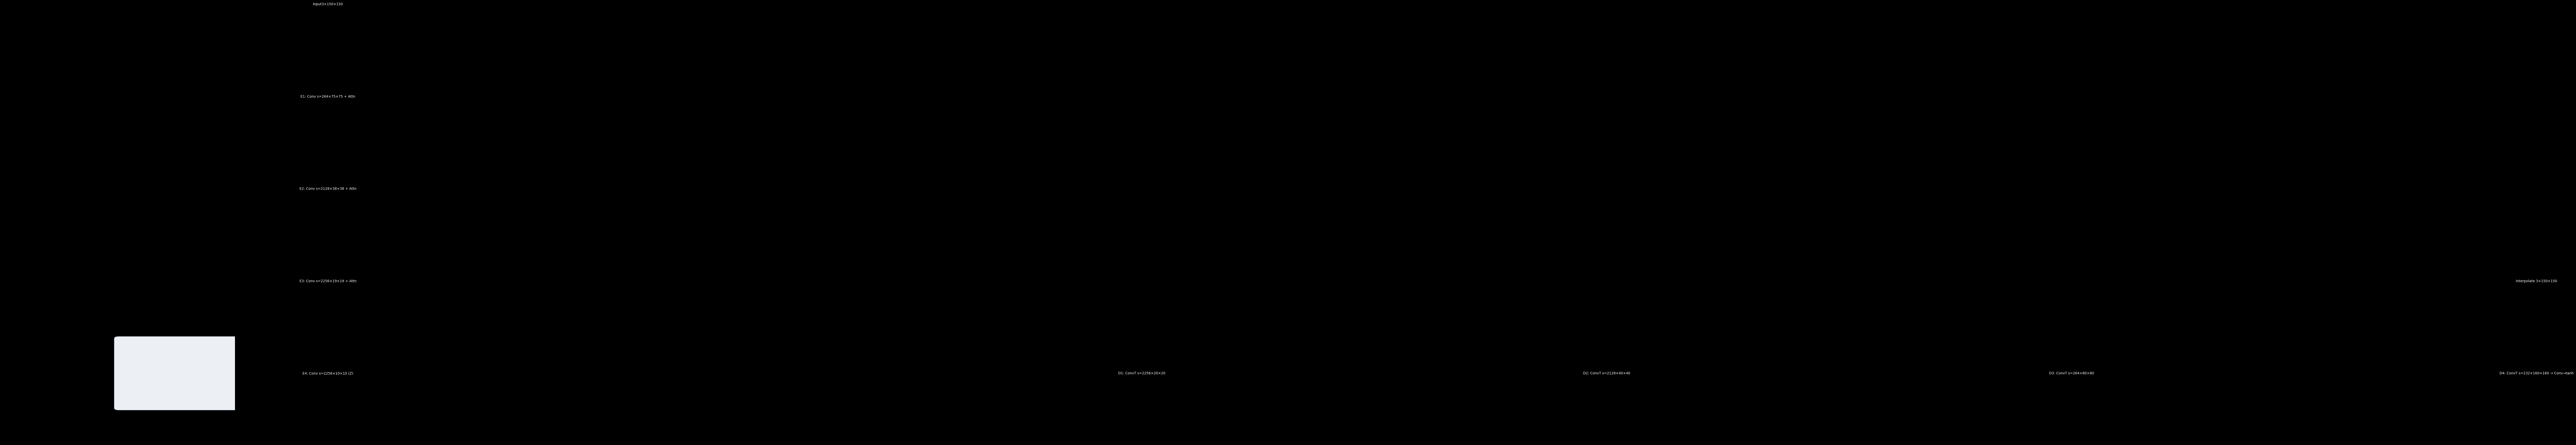

In [7]:
# 13. Flowchart Visualization with matplotlib

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

def box(ax, xy, text, fc='#eceff4'):
    x,y = xy
    w,h = 1.8, 0.6
    rect = FancyBboxPatch((x,y), w, h, boxstyle='round,pad=0.02', fc=fc, ec='#4c566a')
    ax.add_patch(rect)
    ax.text(x+w/2, y+h/2, text, ha='center', va='center', fontsize=10)
    return (x+w/2, y+h)

def arrow(ax, p1, p2):
    ax.annotate('', xy=p2, xytext=p1, arrowprops=dict(arrowstyle='->', lw=1.5, color='#4c566a'))

fig, ax = plt.subplots(figsize=(12,6))
ax.axis('off')

# Encoder chain
c1 = box(ax, (0.5, 3.5), 'Input3×150×150')
c2 = box(ax, (0.5, 2.7), 'E1: Conv s=264×75×75 + Attn')
c3 = box(ax, (0.5, 1.9), 'E2: Conv s=2128×38×38 + Attn')
c4 = box(ax, (0.5, 1.1), 'E3: Conv s=2256×19×19 + Attn')
c5 = box(ax, (0.5, 0.3), 'E4: Conv s=2256×10×10 (Z)')
arrow(ax, (1.4, 3.5), (1.4, 3.3))
arrow(ax, (1.4, 2.7), (1.4, 2.5))
arrow(ax, (1.4, 1.9), (1.4, 1.7))
arrow(ax, (1.4, 1.1), (1.4, 0.9))

# Decoder chain
d1 = box(ax, (4.0, 0.3), 'D1: ConvT s=2256×20×20')
d2 = box(ax, (6.0, 0.3), 'D2: ConvT s=2128×40×40')
d3 = box(ax, (8.0, 0.3), 'D3: ConvT s=264×80×80')
d4 = box(ax, (10.0, 0.3), 'D4: ConvT s=232×160×160 → Conv→tanh')
out = box(ax, (10.0, 1.1), 'Interpolate 3×150×150')

# Main arrows
arrow(ax, (2.3, 0.6), (4.0, 0.6))
arrow(ax, (5.8, 0.6), (6.0, 0.6))
arrow(ax, (7.8, 0.6), (8.0, 0.6))
arrow(ax, (9.8, 0.6), (10.0, 0.6))
arrow(ax, (10.9, 0.9), (10.9, 1.1))

# Skip arrows (schematic)
arrow(ax, (1.4, 1.4), (4.0, 0.6))   # E3 -> D1
arrow(ax, (1.4, 2.2), (6.0, 0.6))   # E2 -> D2
arrow(ax, (1.4, 3.0), (8.0, 0.6))   # E1 -> D3

plt.show()

## 14. Complexity (Rough MACs)

For Conv2d with output H_o×W_o and C_out filters of size k×k over C_in channels, cost ≈ H_o·W_o·C_out·(k²·C_in).
The encoder/decoder here totals on the order of a few hundred MFLOPs per forward pass for batch size 1.

## 15. Practical Notes

- Use RGB normalization mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5).
- Output tanh to match [−1,1].
- Learning rate scheduling (e.g., ReduceLROnPlateau) helps convergence.
- Interpolate to exact (150,150) to handle odd dimensions with stride-2 pyramids.
- Channel attention boosts relevant features; skips preserve edges and textures.